In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from numpy.linalg import LinAlgError
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import boxcox

In [34]:
river_df = pd.read_csv('stations/station_6335050_river_data.csv')
river_df.date = pd.to_datetime(river_df.date, format='%Y-%m-%d')
river_df = river_df.set_index('date')

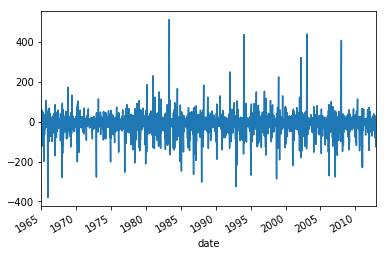

In [90]:
river_df.delta1.plot()

In [43]:
def predict_values(df, pred_start, pred_end):
    head_df = df[df.index < pred_start]
    norm, lambd = boxcox(head_df.water_level.values)
    print(f'Lambda: {lambd}')
    head_df['log_level'] = (head_df.water_level**lambd - 1)/lambd
    
    arima = ARIMA(head_df.log_level.values[1:], (1,1,1))
    try:
        arima_fit = arima.fit()
        pred = arima_fit.model.predict(arima_fit.params, arima_fit.n_totobs, arima_fit.n_totobs + 16, dynamic=True, typ='levels')
    except LinAlgError as e:
        arima = ARIMA(head_df.log_level.values[1:], (2,0,2))
        arima_fit = arima.fit()
        pred = arima_fit.model.predict(arima_fit.params, arima_fit.n_totobs, arima_fit.n_totobs + 16)
    
    pred_dates = pd.date_range(pred_start, pred_end).to_series().reset_index(drop=True)
    
    def invboxcox(y):
          return ((y*lambd)+1)**(1/lambd)
    
    df.loc[pred_dates, 'water_level'] = invboxcox(pred)
    

Working with gap 1968-03-12 00:00:00 - 1968-03-28 00:00:00.
Lambda: -13.802243600134728
Working with gap 1968-06-26 00:00:00 - 1968-07-12 00:00:00.
Lambda: 0.860483892348445
Working with gap 1968-10-10 00:00:00 - 1968-10-26 00:00:00.
Lambda: 0.8545913653274789
Working with gap 1969-01-24 00:00:00 - 1969-02-09 00:00:00.
Lambda: 0.823180517666117
Working with gap 1969-05-10 00:00:00 - 1969-05-26 00:00:00.
Lambda: 0.8286383130965898
Working with gap 1969-08-24 00:00:00 - 1969-09-09 00:00:00.
Lambda: 0.8254004103888808
Working with gap 1969-12-08 00:00:00 - 1969-12-24 00:00:00.
Lambda: 0.8042034482220263
Working with gap 1970-03-24 00:00:00 - 1970-04-09 00:00:00.
Lambda: 0.7266114298525269
Working with gap 1970-07-08 00:00:00 - 1970-07-24 00:00:00.
Lambda: 0.7380021953260378
Working with gap 1970-10-22 00:00:00 - 1970-11-07 00:00:00.
Lambda: 0.7298394196876439
Working with gap 1971-02-05 00:00:00 - 1971-02-21 00:00:00.
Lambda: 0.7076903812061296
Working with gap 1971-05-22 00:00:00 - 1971-

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

KeyError: "[Timestamp('2013-01-14 00:00:00'), Timestamp('2013-01-07 00:00:00'), Timestamp('2013-01-06 00:00:00'), Timestamp('2013-01-08 00:00:00'), Timestamp('2013-01-13 00:00:00'), Timestamp('2013-01-11 00:00:00'), Timestamp('2013-01-15 00:00:00'), Timestamp('2013-01-16 00:00:00'), Timestamp('2013-01-10 00:00:00'), Timestamp('2013-01-12 00:00:00'), Timestamp('2013-01-17 00:00:00'), Timestamp('2013-01-09 00:00:00')] not in index"

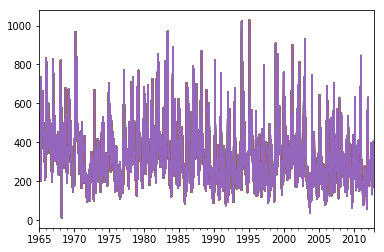

In [44]:
full_range = pd.date_range(river_df.index.min(), river_df.index.max()+pd.Timedelta(days=1)) #TODO add last day!
river_df = river_df.reindex(full_range, fill_value=np.NaN)

next_gap = river_df.water_level.isnull().idxmax()
tail_gap = next_gap + pd.Timedelta(days=16)

while next_gap:
    print(f'Working with gap {next_gap} - {tail_gap}.')
    predict_values(river_df, next_gap, tail_gap)
    river_df[river_df.index <= tail_gap].water_level.plot()
    
    next_gap = river_df.water_level.isnull().idxmax()
    tail_gap = next_gap + pd.Timedelta(days=16)

In [48]:
river_df[['water_level']].to_csv('station6335050_water_level.csv')

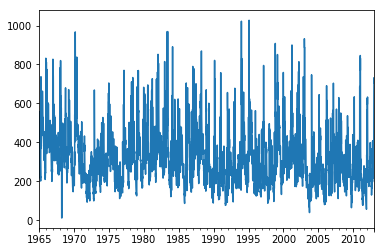

In [46]:
river_df.water_level.plot()